In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

In [2]:
import warnings
warnings.filterwarnings("ignore")
from plotnine import *
from tqdm import tqdm
from joblib import Parallel, delayed # for parallel processing
tqdm._instances.clear() 

## Create Treatment Data v1

Both stores have same number of members. We can get an unbiased estimate of the population mean spending among customers if the number of treated is the same in both stores.

In [63]:
np.random.seed(88)

def run_campaign(biased=False):
    true_mu1treated , true_mu2treated = 20, 40
    n, p , obs = 1, .5 , 2000 # number of trials, probability of each trial, number of observations
    store = np.random.binomial(n, p, obs)+1
    df = pd.DataFrame({'store':store})

    probtreat1 = .5
    if biased:
        probtreat2 = .9
    else:
        probtreat2 = .5
    
    treat = lambda x: int(np.random.binomial(1, probtreat1, 1)) if x==1 else int(np.random.binomial(1, probtreat2, 1)) 
    
    spend = lambda x: float(np.random.normal(true_mu1treated, 3, 1)) if (x[0]==1 and x[1]==1) else ( float(np.random.normal(true_mu2treated, 3, 1) ) )

    df['treated'] = df['store'].apply(treat)
    df['spend'] = df[['store','treated']].apply(tuple,1).apply(spend)
    
    simple_value_treated = np.mean(df.query('treated==1')['spend'])
        
    return [simple_value_treated]

In [64]:
run_campaign()

[30.139604561508058]

## Run Simulation Simple Unbiased

In [81]:
tqdm._instances.clear() 
sim = 1000

values = Parallel(n_jobs=4)(delayed(run_campaign)() for _ in tqdm(range(sim)) )
results_df = pd.DataFrame(values, columns=['simple_treat'])

for c in results_df.columns.tolist():
    print(f"Mean value computed {c}: {round(results_df[c].mean(),3)}, 95% C.I.: {(round(np.percentile(results_df[c], 2.5),3), round(np.percentile(results_df[c], 97.5),3))}")

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 438.96it/s]


Mean value computed simple_treat: 29.997, 95% C.I.: (29.352, 30.618)


### Plot Results

In [82]:
results_df_treat_long = pd.melt(results_df, value_vars=['simple_treat'])

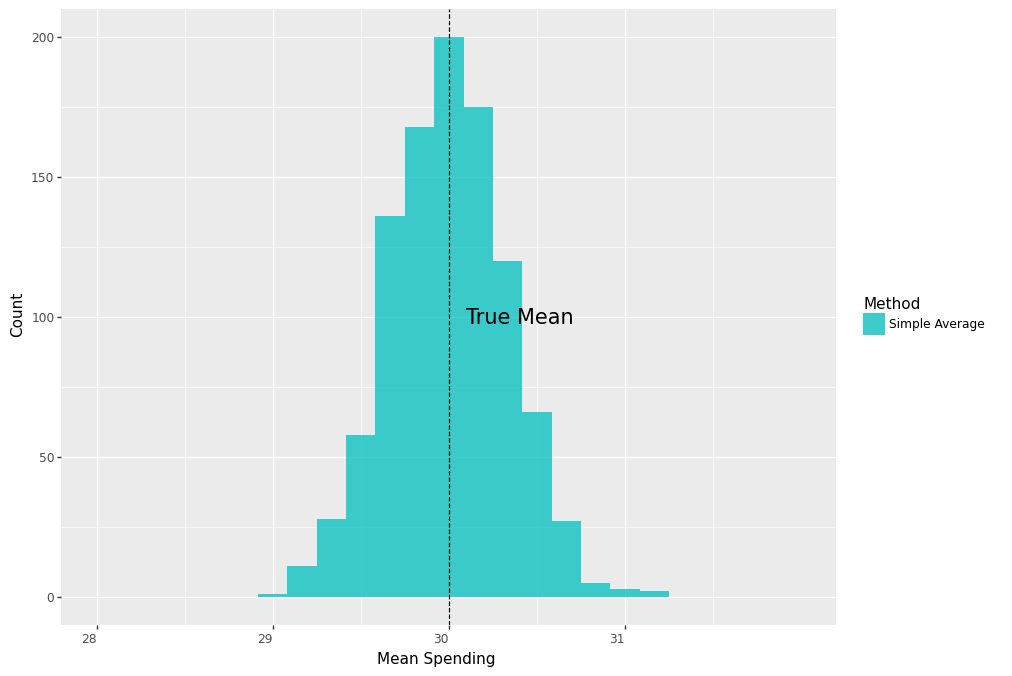

<ggplot: (694683106)>

In [83]:
p_simple = (ggplot(results_df_treat_long, aes(x='value' ,fill='variable'))+
 geom_histogram(alpha=.75, bins=25) +
  xlab('Mean Spending') + ylab('Count') +
 #labs(title="Simulated Campaign Results for Treated")+
 geom_vline(xintercept=true_mutreated, colour='black', linetype='dashed' ) + 
    labs(fill='Method')  +
     scale_fill_manual(labels = ["Simple Average"],values = ["c"] )+
         scale_x_continuous(breaks=list(range(28,32,1)),limits=[28, 32])+      
    annotate("text", x=30.4, y=100, label="True Mean", size=15)+
  theme(figure_size=(10, 8)) +
  theme(axis_text_x = element_text(angle = 0, hjust = 1))
)
p_simple

In [145]:
ggplot.save(p_simple,"HistSimple")

## Run Simulation Simple Biased

In [65]:
run_campaign(biased=True)

[32.75930082115467]

In [84]:
tqdm._instances.clear() 
sim = 1000

values = Parallel(n_jobs=4)(delayed(run_campaign)(biased=True) for _ in tqdm(range(sim)) )
results_df = pd.DataFrame(values, columns=['simple_treat'])

for c in results_df.columns.tolist():
    print(f"Mean value computed {c}: {round(results_df[c].mean(),3)}, 95% C.I.: {(round(np.percentile(results_df[c], 2.5),3), round(np.percentile(results_df[c], 97.5),3))}")

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 437.58it/s]


Mean value computed simple_treat: 32.851, 95% C.I.: (32.355, 33.356)


In [85]:
results_df_treat_long = pd.melt(results_df, value_vars=['simple_treat'])

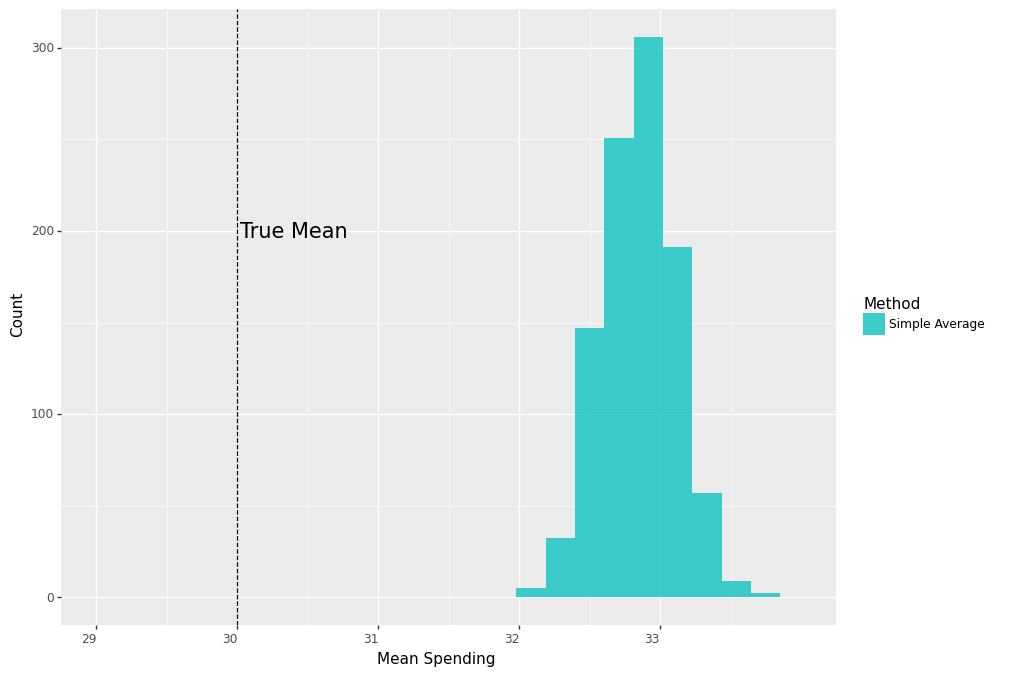

<ggplot: (692245465)>

In [87]:
p_biased = (ggplot(results_df_treat_long, aes(x='value' ,fill='variable'))+
 geom_histogram(alpha=.75, bins=25) +
  xlab('Mean Spending') + ylab('Count') +
 #labs(title="Simulated Campaign Results for Treated")+
 geom_vline(xintercept=true_mutreated, colour='black', linetype='dashed' ) + 
    labs(fill='Method')  +
     scale_fill_manual(labels = ["Simple Average"],values = ["c"] )+
         scale_x_continuous(breaks=list(range(29,34,1)),limits=[29, 34])+      
    annotate("text", x=30.4, y=200, label="True Mean", size=15)+
  theme(figure_size=(10, 8)) +
  theme(axis_text_x = element_text(angle = 0, hjust = 1))
)
p_biased

In [144]:
ggplot.save(p_biased,"HistSimpleBiased")

## Create Campaign Data v2

In [88]:
np.random.seed(88)

def run_campaign2():
    true_mu1treated , true_mu2treated = 20, 40

    n, p , obs = 1, .5 , 2000 # number of trials, probability of each trial, number of observations
    store = np.random.binomial(n, p, obs)+1
    df = pd.DataFrame({'store':store})

    probtreat1 = .5
    probtreat2 = .9
    
    treat = lambda x: int(np.random.binomial(1, probtreat1, 1)) if x==1 else int(np.random.binomial(1, probtreat2, 1)) 
    
    spend = lambda x: float(np.random.normal(true_mu1treated, 3, 1)) if (x[0]==1 and x[1]==1) else ( float(np.random.normal(true_mu2treated, 3, 1) ) )

    df['treated'] = df['store'].apply(treat)
    df['spend'] = df[['store','treated']].apply(tuple,1).apply(spend)
    
    simple_value_treated = np.mean(df.query('treated==1')['spend'])

    
    prob1 = df.query('store==1').shape[0]/df.shape[0]
    prob2 = df.query('store==2').shape[0]/df.shape[0]
    
    
    est_mu1treated = np.mean(df.query('treated==1 & store==1')['spend'])
    est_mu2treated = np.mean(df.query('treated==1 & store==2')['spend'])

    weighted_value_treated = prob1*est_mu1treated + prob2*est_mu2treated
    
    return [simple_value_treated, weighted_value_treated]

In [89]:
run_campaign2()

[33.18465520598871, 30.21741176723726]

## Run Simulation

In [147]:
tqdm._instances.clear() 
sim = 1000

values = Parallel(n_jobs=4)(delayed(run_campaign2)() for _ in tqdm(range(sim)) )
results_df = pd.DataFrame(values, columns=['simple_treat','weighted_treat'])

for c in results_df.columns.tolist():
    print(f"Mean value computed {c}: {round(results_df[c].mean(),3)}, 95% C.I.: {(round(np.percentile(results_df[c], 2.5),3), round(np.percentile(results_df[c], 97.5),3))}")

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 328.26it/s]


Mean value computed simple_treat: 32.847, 95% C.I.: (32.311, 33.395)
Mean value computed weighted_treat: 29.997, 95% C.I.: (29.526, 30.435)


## Plot Results

In [148]:
results_df_treat_long = pd.melt(results_df, value_vars=['simple_treat','weighted_treat'])

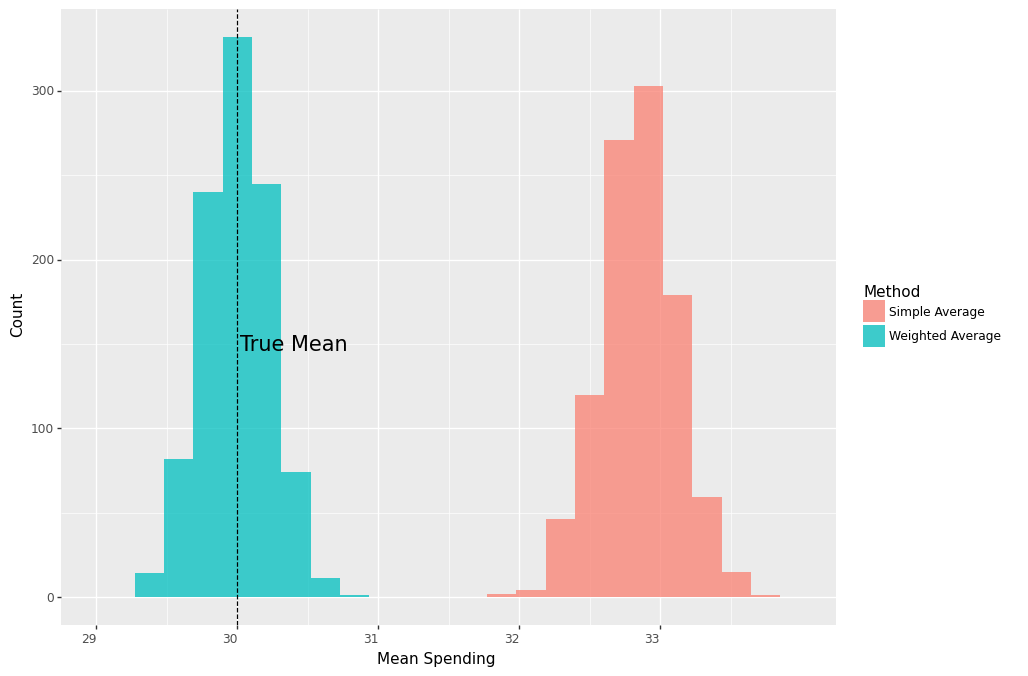

<ggplot: (692196015)>

In [149]:
p_treat = (ggplot(results_df_treat_long, aes(x='value' ,fill='variable'))+
 geom_histogram(alpha=.75, bins=25) +
  xlab('Mean Spending') + ylab('Count') +
 # labs(title="Simulated Campaign Results for Treated")+
 geom_vline(xintercept=true_mutreated, colour='black', linetype='dashed' ) + 
    labs(fill='Method')  +
     scale_fill_manual(labels = ["Simple Average","Weighted Average"],values = ["salmon", "c"] )+
         scale_x_continuous(breaks=list(range(29,34,1)),limits=[29, 34])+      
    annotate("text", x=30.4, y=150, label="True Mean", size=15)+
  theme(figure_size=(10, 8)) +
  theme(axis_text_x = element_text(angle = 0, hjust = 1))
)
p_treat

In [150]:
ggplot.save(p_treat,"HistWeightedVsSimple")

## Create Campaign Data v3

In [94]:
np.random.seed(88)

def run_campaign3():
    true_mu1treated , true_mu2treated = 20, 40

    n, p , obs = 1, .5 , 2000 # number of trials, probability of each trial, number of observations
    store = np.random.binomial(n, p, obs)+1
    df = pd.DataFrame({'store':store})

    probtreat1 = .5
    probtreat2 = .9
    
    treat = lambda x: int(np.random.binomial(1, probtreat1, 1)) if x==1 else int(np.random.binomial(1, probtreat2, 1)) 
    
    spend = lambda x: float(np.random.normal(true_mu1treated, 3, 1)) if (x[0]==1 and x[1]==1) else ( float(np.random.normal(true_mu2treated, 3, 1) ) )

    df['treated'] = df['store'].apply(treat)
    df['spend'] = df[['store','treated']].apply(tuple,1).apply(spend)
    
    prob1 = df.query('store==1').shape[0]/df.shape[0]
    prob2 = df.query('store==2').shape[0]/df.shape[0]
    
    simple_value_treated = np.mean(df.query('treated==1')['spend'])
    
    #estimate propensity score:
    ps1 = df.query('treated==1 & store==1').shape[0]/df.query('store==1').shape[0]
    ps2 = df.query('treated==1 & store==2').shape[0]/df.query('store==2').shape[0]

    df['ps'] = pd.Series(np.where(df['store']==1, ps1, ps2))

    ipw_value_treated = np.mean( (df['spend']*df['treated'])/df['ps'])
    
    return [simple_value_treated, ipw_value_treated]

In [151]:
tqdm._instances.clear() 
sim = 1000

values = Parallel(n_jobs=4)(delayed(run_campaign3)() for _ in tqdm(range(sim)) )
results_df = pd.DataFrame(values, columns=['simple_treat','ipw_treat'])

for c in results_df.columns.tolist():
    print(f"Mean value computed {c}: {round(results_df[c].mean(),3)}, 95% C.I.: {(round(np.percentile(results_df[c], 2.5),3), round(np.percentile(results_df[c], 97.5),3))}")

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 350.71it/s]


Mean value computed simple_treat: 32.854, 95% C.I.: (32.334, 33.347)
Mean value computed ipw_treat: 29.988, 95% C.I.: (29.517, 30.451)


In [152]:
results_df_treat_long = pd.melt(results_df, value_vars=['simple_treat','ipw_treat'])

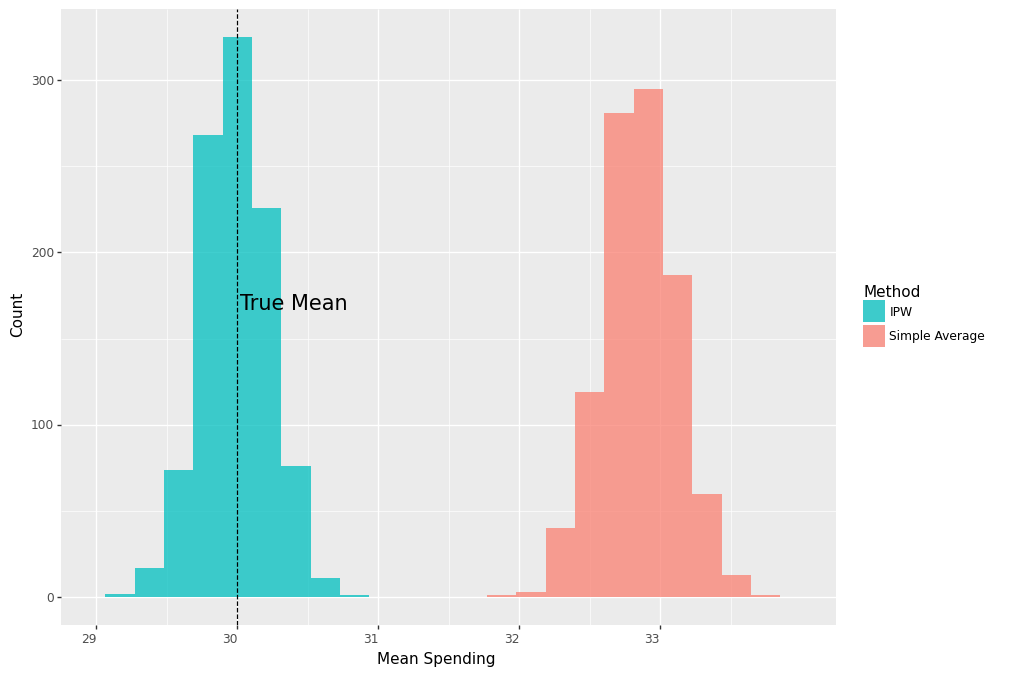

<ggplot: (692298406)>

In [153]:
p_ipw = (ggplot(results_df_treat_long, aes(x='value' ,fill='variable'))+
 geom_histogram(alpha=.75, bins=25) +
  xlab('Mean Spending') + ylab('Count') +
 # labs(title="Simulated Campaign Results for Treated")+
 geom_vline(xintercept=true_mutreated, colour='black', linetype='dashed' ) + 
    labs(fill='Method')  +
     scale_fill_manual(labels = ["IPW","Simple Average"],values = ["c", "salmon"] )+
         scale_x_continuous(breaks=list(range(29,34,1)),limits=[29, 34])+      
    annotate("text", x=30.4, y=170.5, label="True Mean", size=15)+
  theme(figure_size=(10, 8)) +
  theme(axis_text_x = element_text(angle = 0, hjust = 1))
)
p_ipw

In [154]:
ggplot.save(p_ipw,"featured")

In [155]:
np.random.seed(88)

def run_campaign4():
    true_mu1treated , true_mu2treated = 20, 40
    true_mu1control , true_mu2control = 10, 10
    n, p , obs = 1, .5 , 1000 # number of trials, probability of each trial, number of observations
    store = np.random.binomial(n, p, obs)+1
    df = pd.DataFrame({'store':store})

    probtreat1 = .5
    probtreat2 = .9
    
    treat = lambda x: int(np.random.binomial(1, probtreat1, 1)) if x==1 else int(np.random.binomial(1, probtreat2, 1)) 
    
    spend = lambda x: float(np.random.normal(true_mu1treated, 3, 1)) if (x[0]==1 and x[1]==1) else ( float(np.random.normal(true_mu2treated, 3, 1) ) if  (x[0]==2 and x[1]==1)   
                                                                                              else (float(np.random.normal(true_mu1control, 2, 1) ) if  (x[0]==1 and x[1]==0)  
                                                                                              else  float(np.random.normal(true_mu2control, 2, 1))     ))

    df['treated'] = df['store'].apply(treat)
    df['spend'] = df[['store','treated']].apply(tuple,1).apply(spend)
    
    prob1 = df.query('store==1').shape[0]/df.shape[0]
    prob2 = df.query('store==2').shape[0]/df.shape[0]
    
    simple_value_treated = np.mean(df.query('treated==1')['spend'])
    simple_value_control = np.mean(df.query('treated==0')['spend'])
    
    simple_tau = simple_value_treated - simple_value_control
    
    est_mu1treated = np.mean(df.query('treated==1 & store==1')['spend'])
    est_mu2treated = np.mean(df.query('treated==1 & store==2')['spend'])

    weighted_value_treated = prob1*est_mu1treated + prob2*est_mu2treated
        
    est_mu1control = np.mean(df.query('treated==0 & store==1')['spend'])
    est_mu2control = np.mean(df.query('treated==0 & store==2')['spend'])
    
    weighted_value_control = prob1*est_mu1control + prob2*est_mu2control
    
    weighted_tau = weighted_value_treated - weighted_value_control
    
    #estimate propensity score:
    ps1 = df.query('treated==1 & store==1').shape[0]/df.query('store==1').shape[0]
    ps2 = df.query('treated==1 & store==2').shape[0]/df.query('store==2').shape[0]

    df['ps'] = pd.Series(np.where(df['store']==1, ps1, ps2))

    ipw_value_treated = np.mean( (df['spend']*df['treated'])/df['ps'])
    ipw_value_control = np.mean( (df['spend']*(1-df['treated']) )/(1-df['ps'] ))
    ipw_tau = ipw_value_treated - ipw_value_control
    
    return [simple_tau, weighted_tau, ipw_tau]

In [156]:
tqdm._instances.clear() 
sim = 1000

values = Parallel(n_jobs=4)(delayed(run_campaign4)() for _ in tqdm(range(sim)) )
results_df = pd.DataFrame(values, columns=['simple_tau','weighted_tau','ipw_tau'])

for c in results_df.columns.tolist():
    print(f"Mean value computed {c}: {round(results_df[c].mean(),3)}, 95% C.I.: {(round(np.percentile(results_df[c], 2.5),3), round(np.percentile(results_df[c], 97.5),3))}")

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 355.26it/s]


Mean value computed simple_tau: 22.855, 95% C.I.: (22.093, 23.679)
Mean value computed weighted_tau: 19.988, 95% C.I.: (19.258, 20.759)
Mean value computed ipw_tau: 19.988, 95% C.I.: (19.258, 20.759)


In [157]:
results_df_tau_long = pd.melt(results_df, value_vars=['simple_tau', 'weighted_tau','ipw_tau'])

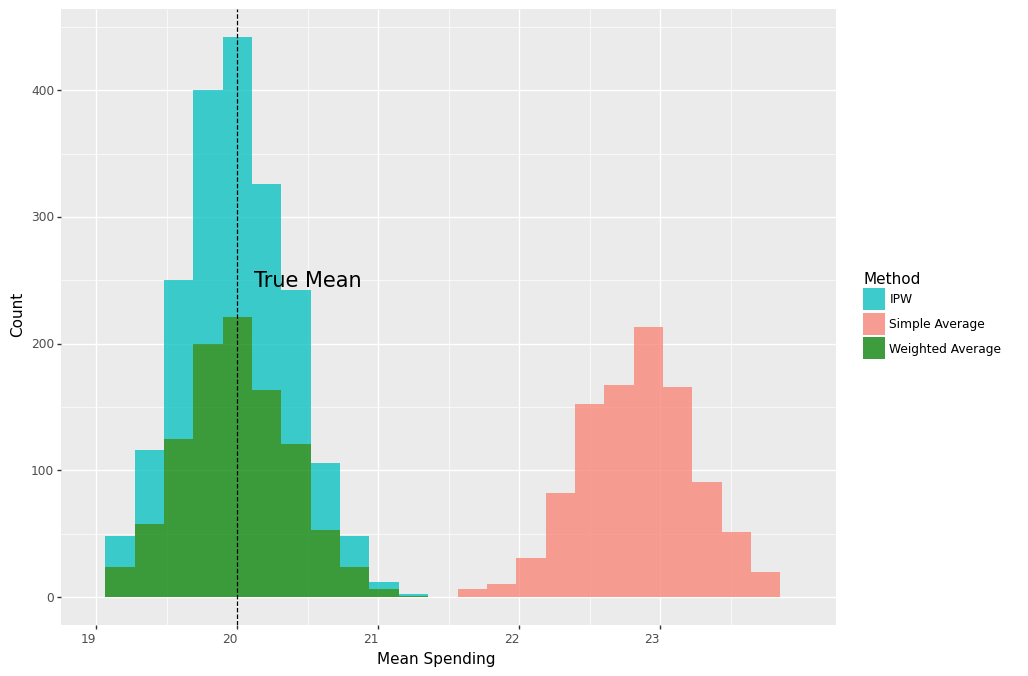

<ggplot: (705152961)>

In [168]:
p_tau = (ggplot(results_df_tau_long, aes(x='value' ,fill='variable'))+
 geom_histogram(alpha=0.75, bins=25) +
  xlab('Mean Spending') + ylab('Count') +
  # labs(title="Simulated Campaign Results of Treatment Effect")+
  geom_vline(xintercept=20, colour='black', linetype='dashed' ) + labs(fill='Method')  +
    scale_fill_manual(labels = ["IPW" ,"Simple Average","Weighted Average"],values = ["c","salmon","green"] )+
    scale_x_continuous(breaks=list(range(19,24,1)),limits=[19, 24])+
    annotate("text", x=20.5, y=250, label="True Mean", size=15)+
  theme(figure_size=(10, 8)) +
  theme(axis_text_x = element_text(angle = 0, hjust = 1))
)
p_tau

In [169]:
ggplot.save(p_tau,"HistEffect")